# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = './data/Lernnavi' # You many change the directory

# Your code goes here

## Task 0: Research Question

**Research question:**
What distinct learning behaviors exist based on platform interactions and patterns over time? Can we categorize students into different learner types?

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [2]:
users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))


In [7]:
users.columns

Index(['user_id', 'gender', 'canton', 'class_level', 'study', 'class_id'], dtype='object')

## Creating the features

### Base Features

In [ ]:
# Example for session features
events['event_date'] = pd.to_datetime(events['event_date'])

session_features = events.groupby(['user_id', 'session_id']).agg({
    'event_date': ['count', lambda x: (x.max() - x.min()).total_seconds()/60],
    'session_closed': 'mean',
    'session_accepted': 'mean',
    'topic_id': 'nunique'
}).reset_index()


### Temporal Features

In [18]:
# Daily activity patterns
daily_activity = events.groupby(['user_id', pd.Grouper(key='event_date', freq='D')])['event_id'].count().unstack(fill_value=0)

# Calculate consistency metrics
temporal_features = daily_activity.apply(lambda x: {
    'active_days': (x > 0).sum(),
    'mean_events': x.mean(),
    'time_var': x.std(),
    'weekend_ratio': x[x.index.weekday >= 5].sum()/x.sum()
}, axis=1)

### Event rhythm features

In [59]:
events['event_date'] = pd.to_datetime(events['event_date'])
events = events.sort_values(by=['user_id', 'event_date'])

# Time between each event
events['time_diff'] = events.groupby('user_id')['event_date'].diff().dt.total_seconds()

event_time_stats = events.groupby('user_id')['time_diff'].agg(['mean', 'std']).reset_index()
event_time_stats.columns = ['user_id', 'avg_time_between_events', 'std_time_between_events']


### Performance Features

In [47]:
# Accuracy by question type
performance_features = transactions.groupby(['user_id', 'type']).agg({
    'commit_time': lambda x: (x - x.shift()).median()
}).unstack()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of e

### Behavioral Sequence Features

In [48]:
# Topic progression patterns
topic_sequences = events.sort_values('event_date').groupby('user_id')['topic_id'].apply(list)
topic_changes = topic_sequences.apply(lambda x: len(set(x)))

In [49]:
# Flatten column names
session_features.columns = ['user_id', 'session_id', 'event_count', 'session_duration_min', 
                            'session_closed_rate', 'session_accepted_rate', 'nb_unique_topics']


In [50]:
session_user_features = session_features.groupby('user_id').agg(
    mean_events_per_session=('event_count', 'mean'),
    mean_session_duration=('session_duration_min', 'mean'),
    mean_session_closed=('session_closed_rate', 'mean'),
    mean_session_accepted=('session_accepted_rate', 'mean'),
    mean_nb_topics=('nb_unique_topics', 'mean')
).reset_index()


In [51]:
# Flatten column names after unstack
performance_features.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in performance_features.columns.values]

# Reset index to bring user_id as a column
performance_features = performance_features.reset_index()


In [61]:
# Task diversity (number of unique question types attempted)
task_diversity = transactions.groupby('user_id')['type'].nunique().reset_index()
task_diversity.columns = ['user_id', 'task_type_diversity']
def safe_mode(series):
    m = series.mode()
    return m.iloc[0] if not m.empty else np.nan

most_common_task_type = transactions.groupby('user_id')['type'].agg(safe_mode).reset_index()
most_common_task_type.columns = ['user_id', 'preferred_task_type']



In [52]:
from functools import reduce
# Convert the Series of dicts to a proper DataFrame
temporal_df = pd.DataFrame(temporal_features.tolist(), index=temporal_features.index).reset_index()
temporal_df = temporal_df.rename(columns={'index': 'user_id'})


dfs_to_merge = [session_user_features, temporal_df, performance_features]
features_final = reduce(lambda left, right: pd.merge(left, right, on='user_id', how='outer'), dfs_to_merge)


In [62]:
dfs_to_merge = [features_final, performance_features, task_diversity, most_common_task_type]  # adapt based on your var names
features_final = reduce(lambda left, right: pd.merge(left, right, on='user_id', how='outer'), dfs_to_merge)

In [63]:
features_final.columns

Index(['user_id', 'mean_events_per_session', 'mean_session_duration',
       'mean_session_closed', 'mean_session_accepted', 'mean_nb_topics',
       'active_days', 'mean_events', 'time_var', 'weekend_ratio',
       'commit_time_CLOZE_MATH_x', 'commit_time_CLOZE_TEXT_x',
       'commit_time_CLOZE_TEXT_DROPDOWN_x', 'commit_time_DND_GROUP_x',
       'commit_time_DND_IN_TEXT_x', 'commit_time_DND_ORDER_x',
       'commit_time_DND_PAIRS_x', 'commit_time_FIX_TEXT_x',
       'commit_time_GRAPH_CLICK_POINTS_x', 'commit_time_GRAPH_SELECT_SHAPE_x',
       'commit_time_GRAPH_SOLUTION_FIELD_x', 'commit_time_HIGHLIGHT_x',
       'commit_time_MATH_STEP_BY_STEP_x', 'commit_time_MULTIPLE_CHOICE_x',
       'commit_time_MULTI_COLOR_HIGHLIGHT_x', 'commit_time_OPEN_TASK_x',
       'commit_time_SEPARATE_TEXT_x', 'commit_time_SOLUTION_FIELD_x',
       'commit_time_CLOZE_MATH_y', 'commit_time_CLOZE_TEXT_y',
       'commit_time_CLOZE_TEXT_DROPDOWN_y', 'commit_time_DND_GROUP_y',
       'commit_time_DND_IN_TEXT

In [ ]:
# # Drop identifiers
# X = features_final.drop(columns=['user_id'], errors='ignore')

# # Keep only numeric
# X = X.select_dtypes(include=['float64', 'int64'])

# # Fill missing values
# X = X.fillna(0)


In [67]:
# from sklearn.feature_selection import VarianceThreshold

# selector = VarianceThreshold(threshold=0.01)
# X_reduced = selector.fit_transform(X)
# selected_cols = X.columns[selector.get_support()]
# X_selected = pd.DataFrame(X_reduced, columns=selected_cols)


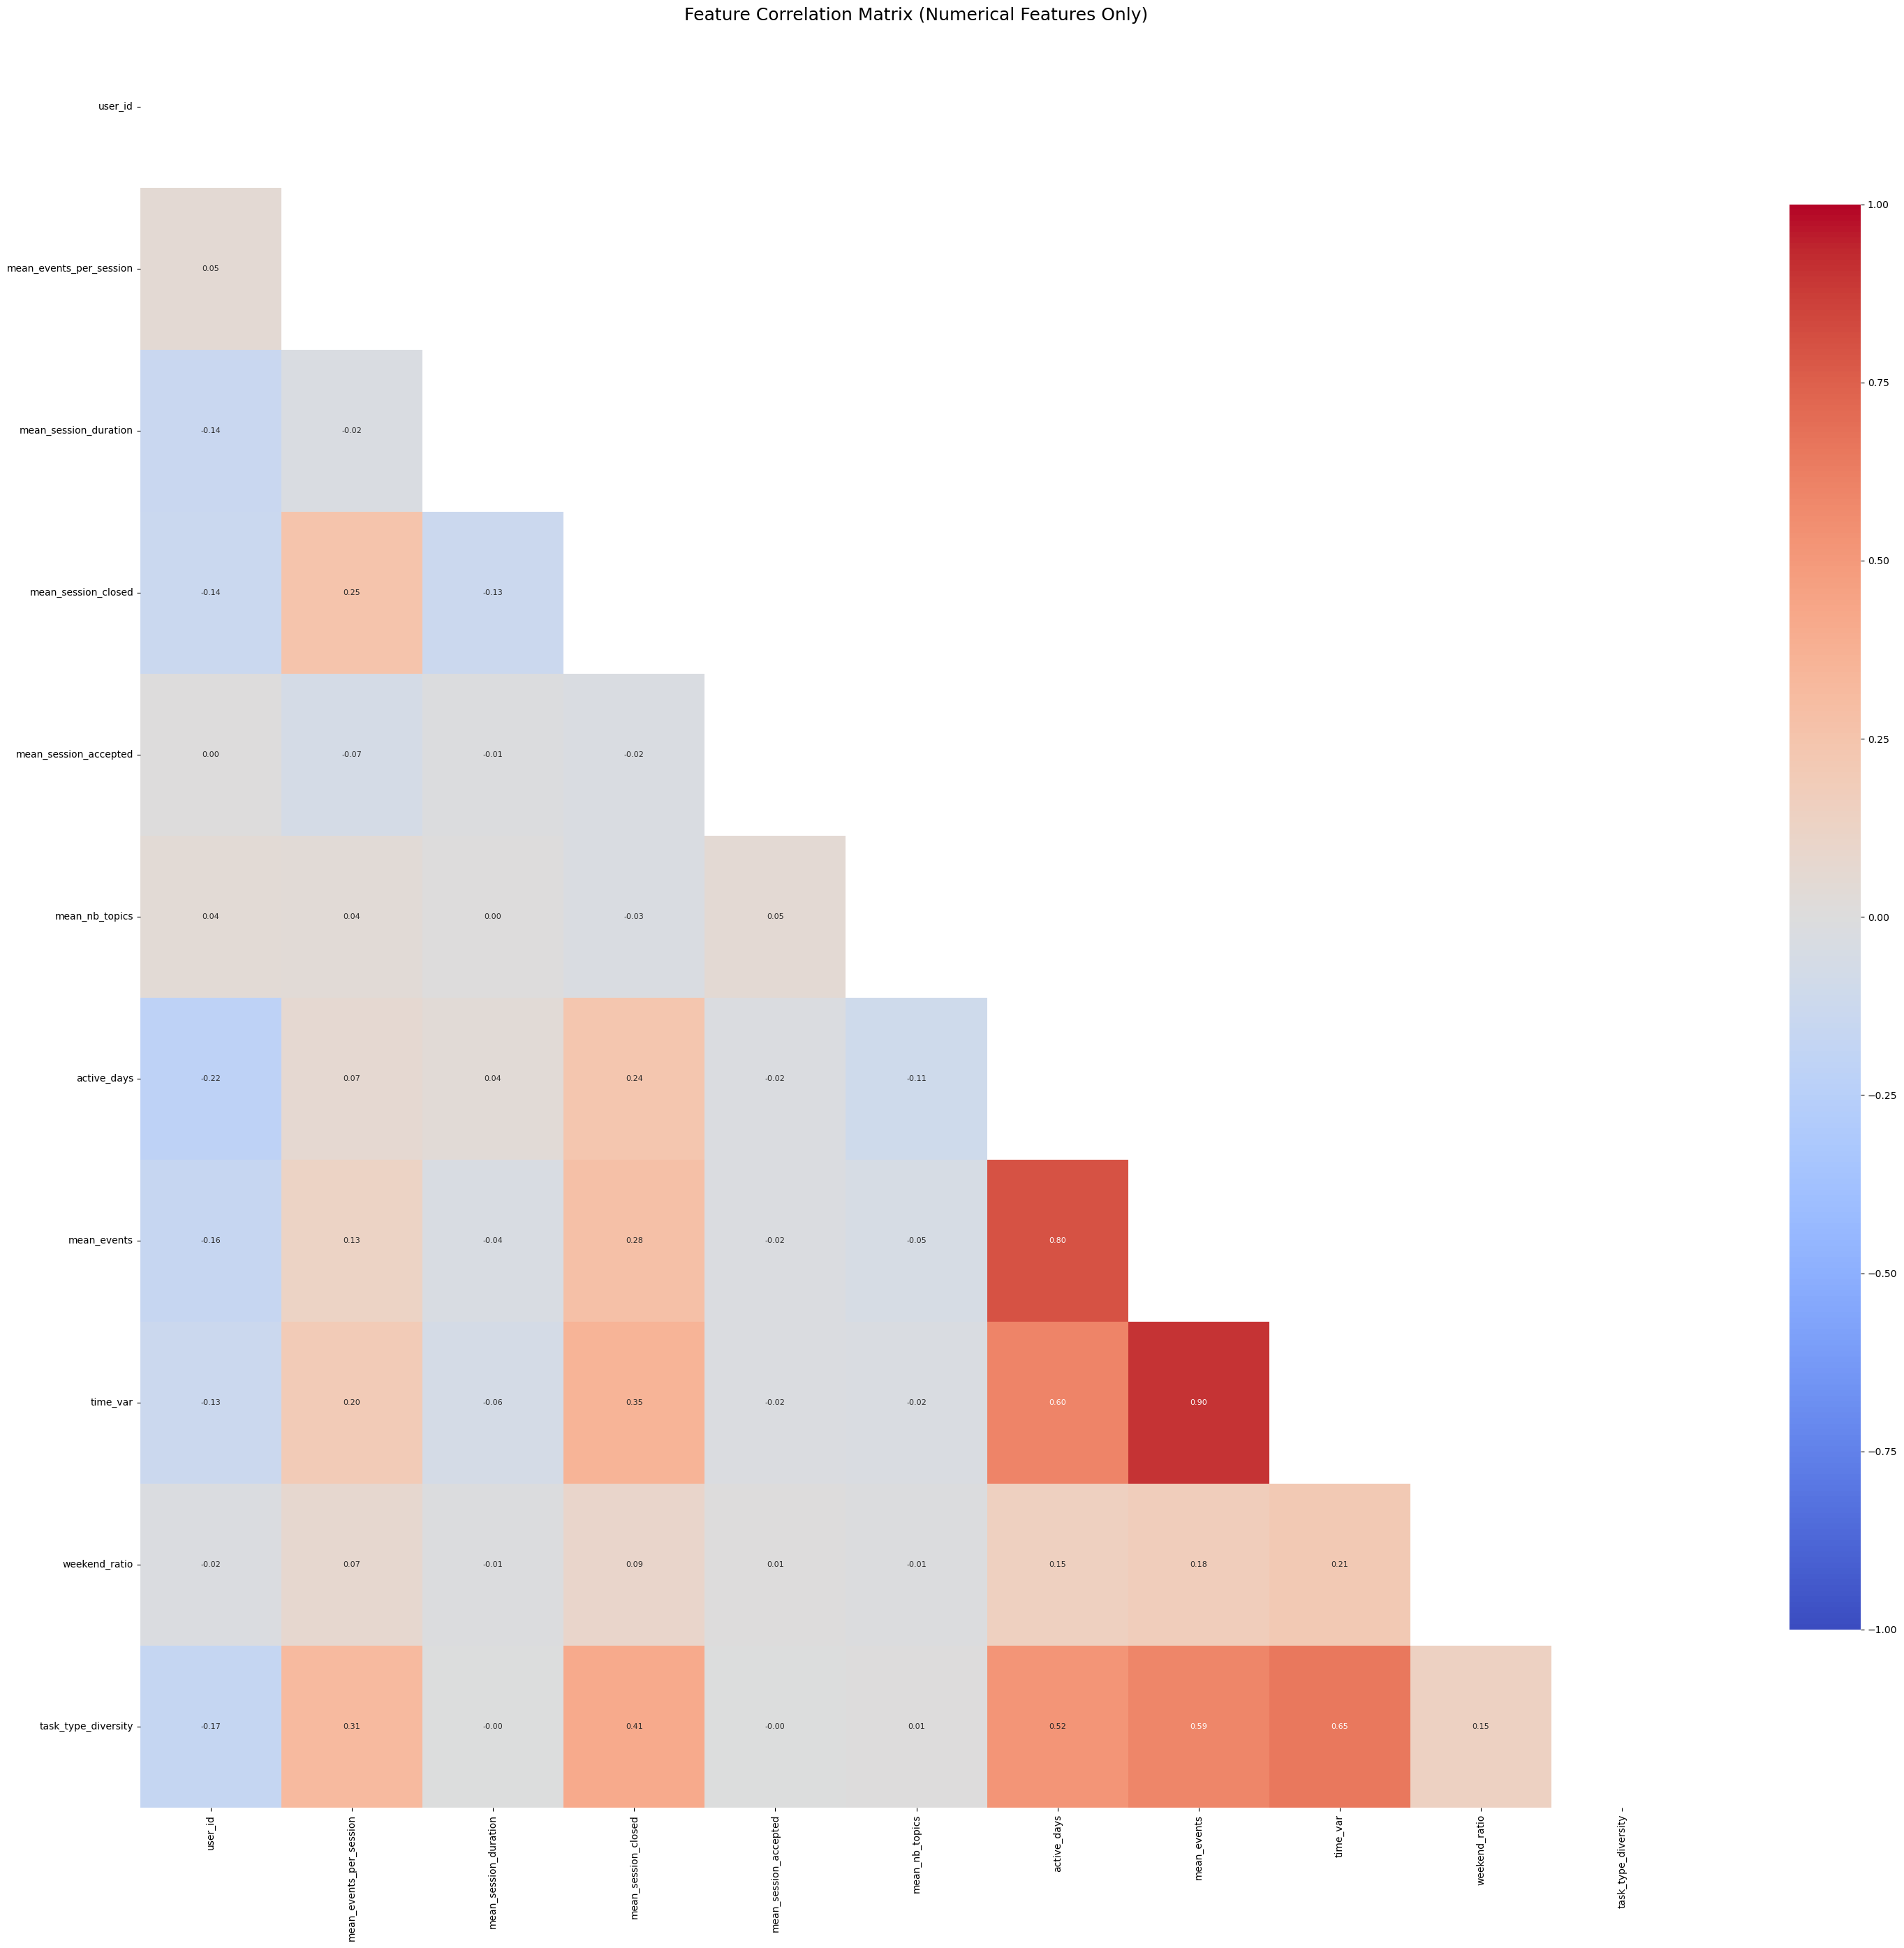

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Make a copy of your dataset
df = features_final.copy()

# 2. Keep only numeric columns (float or int)
corr_features = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[corr_features]

# 3. Compute correlation matrix
corr_matrix = df_numeric.corr()

# 4. Set up the matplotlib figure
plt.figure(figsize=(30, 28))

# 5. Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 6. Draw the heatmap with the mask
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0, 
    vmin=-1, 
    vmax=1,
    annot_kws={"size": 8}, 
    cbar_kws={"shrink": .8}
)

# 7. Styling
plt.title('Feature Correlation Matrix (Numerical Features Only)', fontsize=18)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


In [72]:
df = features_final.copy()
df_numeric = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = df_numeric.corr().abs()  # use absolute correlations
# Create mask for the upper triangle (we only need one triangle of the symmetric matrix)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation above threshold
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"❌ Dropping {len(to_drop)} highly correlated features: {to_drop}")


❌ Dropping 1 highly correlated features: ['time_var']


In [74]:
features_reduced = df_numeric.drop(columns=to_drop)


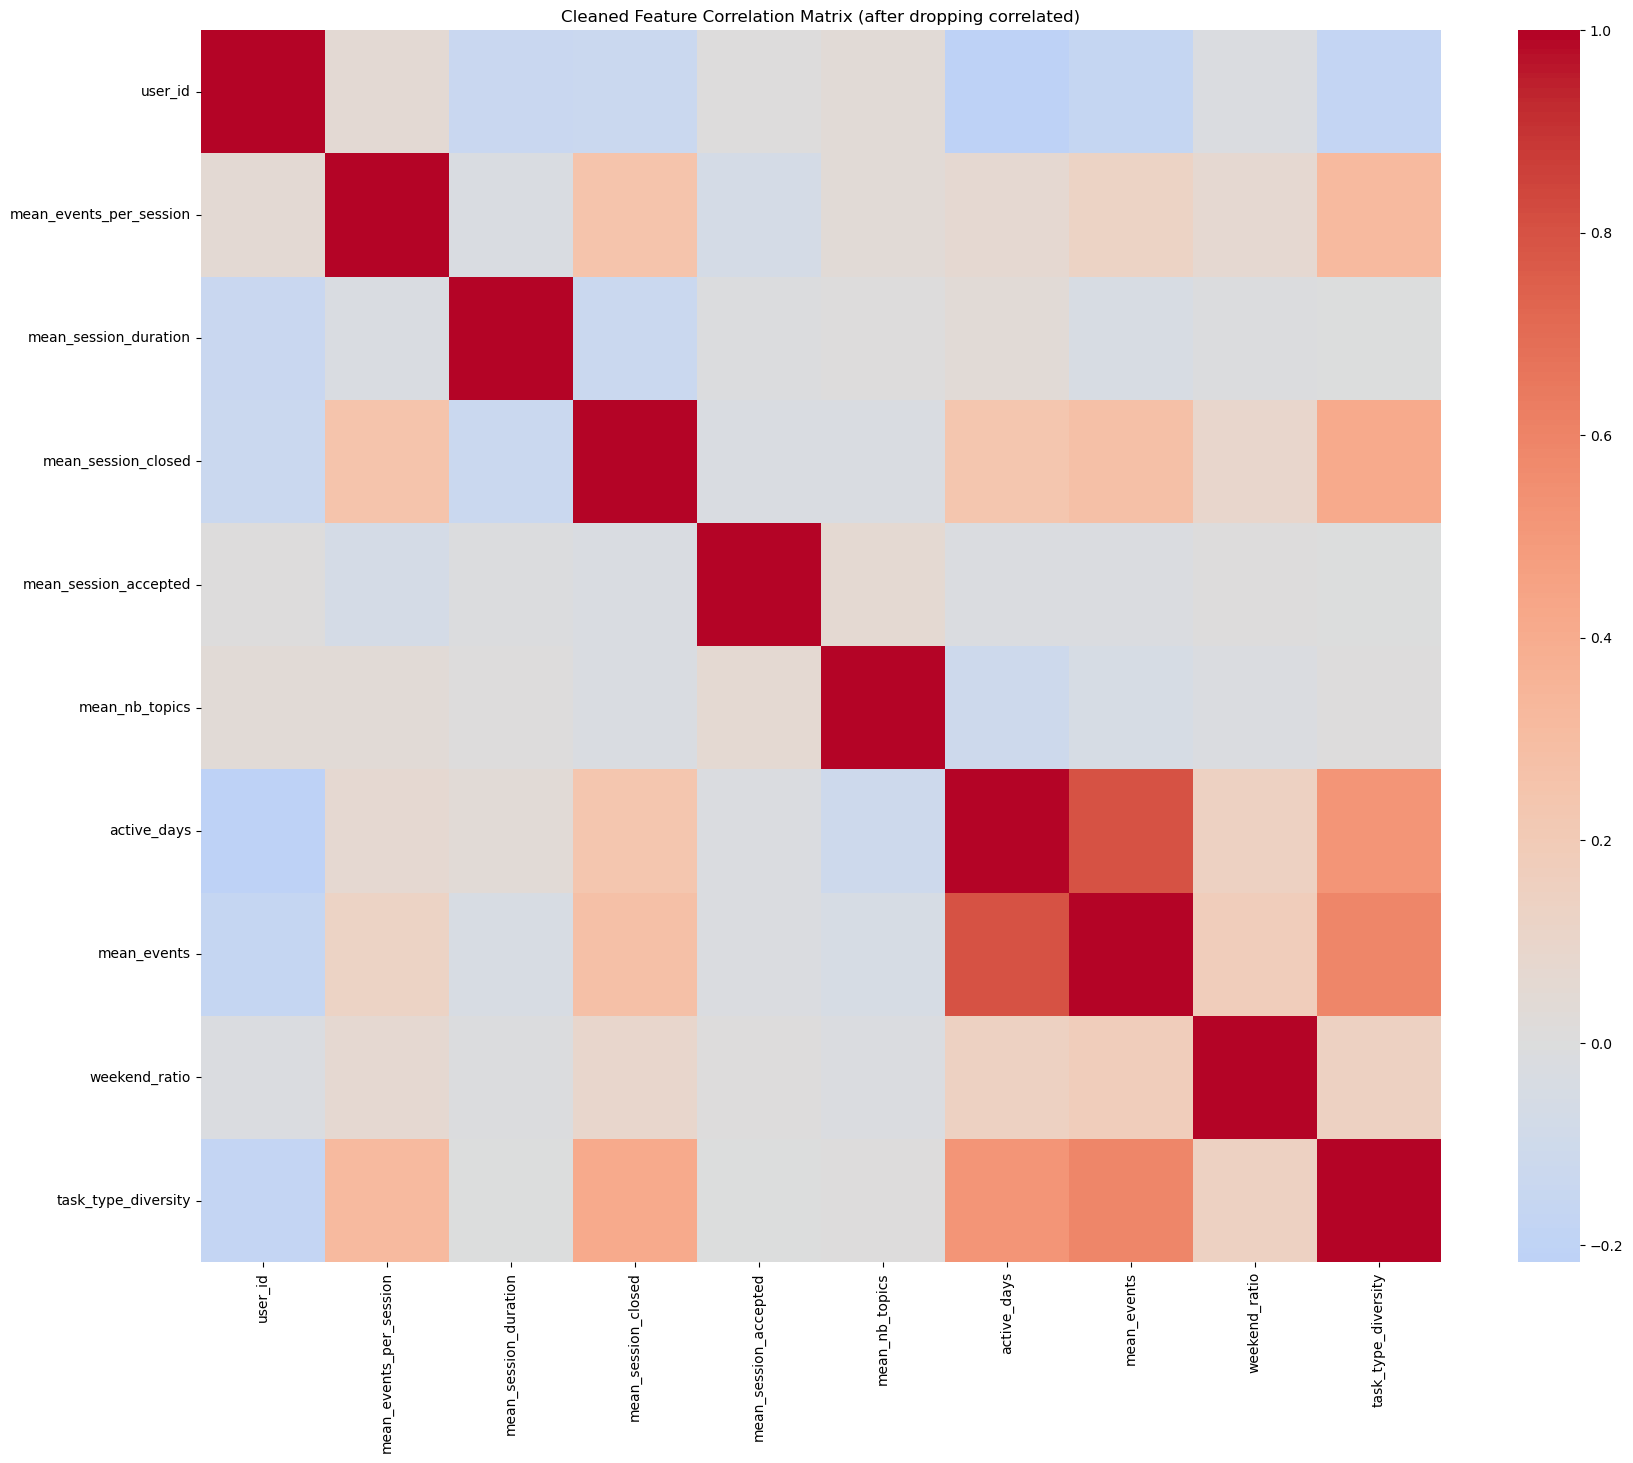

In [75]:
plt.figure(figsize=(20, 16))
sns.heatmap(features_reduced.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Cleaned Feature Correlation Matrix (after dropping correlated)")
plt.show()


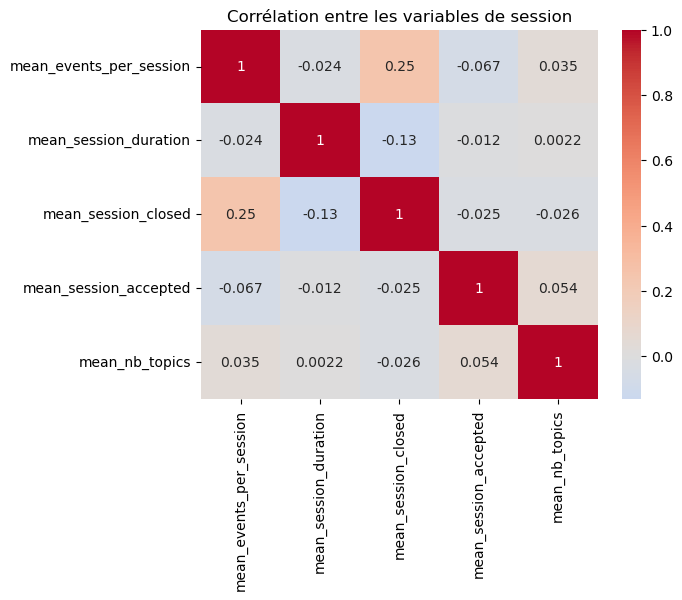

In [55]:
session_cols = [
    'mean_events_per_session', 'mean_session_duration',
    'mean_session_closed', 'mean_session_accepted', 'mean_nb_topics'
]

sns.heatmap(features_final[session_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Corrélation entre les variables de session")
plt.show()


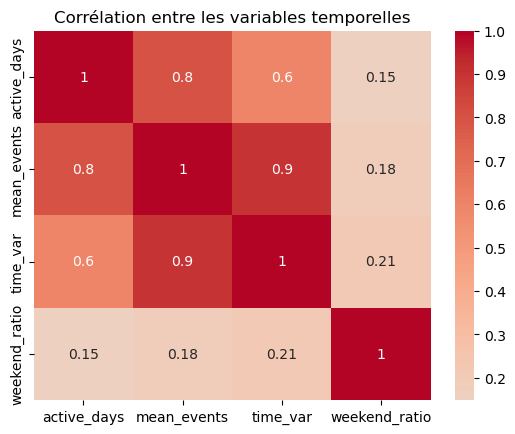

In [56]:
temporal_cols = ['active_days', 'mean_events', 'time_var', 'weekend_ratio']

sns.heatmap(features_final[temporal_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Corrélation entre les variables temporelles")
plt.show()


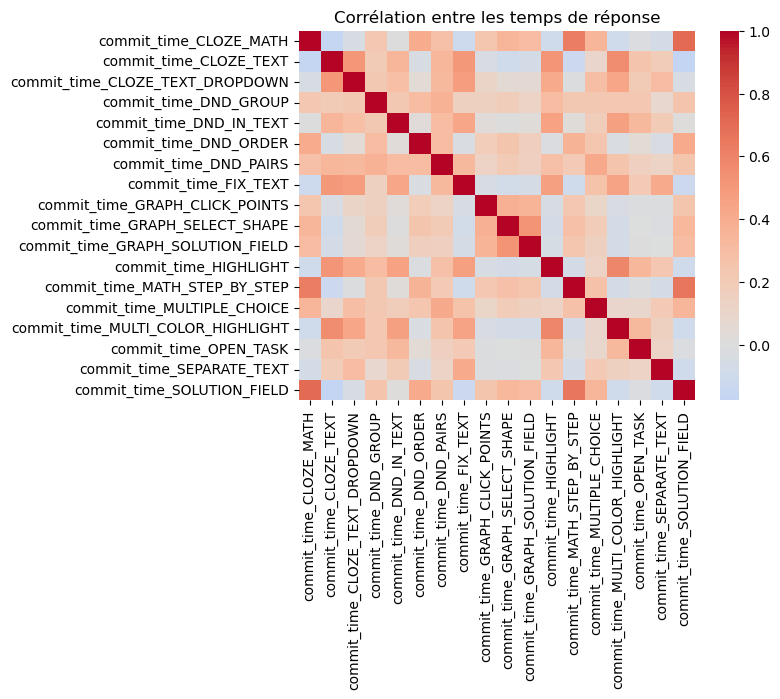

In [ ]:
commit_cols = [col for col in features_final.columns if col.startswith('commit_time_')]

sns.heatmap(features_final[commit_cols].corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Corrélation entre les temps de réponse")
plt.show()


array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'avg_events_per_day'}>,
        <Axes: title={'center': 'nb_unique_categories'}>],
       [<Axes: title={'center': 'session_count'}>,
        <Axes: title={'center': 'session_accepted_rate'}>,
        <Axes: title={'center': 'total_transactions'}>],
       [<Axes: title={'center': 'avg_evaluation'}>,
        <Axes: title={'center': 'nb_unique_docs'}>,
        <Axes: title={'center': 'avg_commit_delay'}>],
       [<Axes: title={'center': 'nb_challenge_attempts'}>, <Axes: >,
        <Axes: >]], dtype=object)

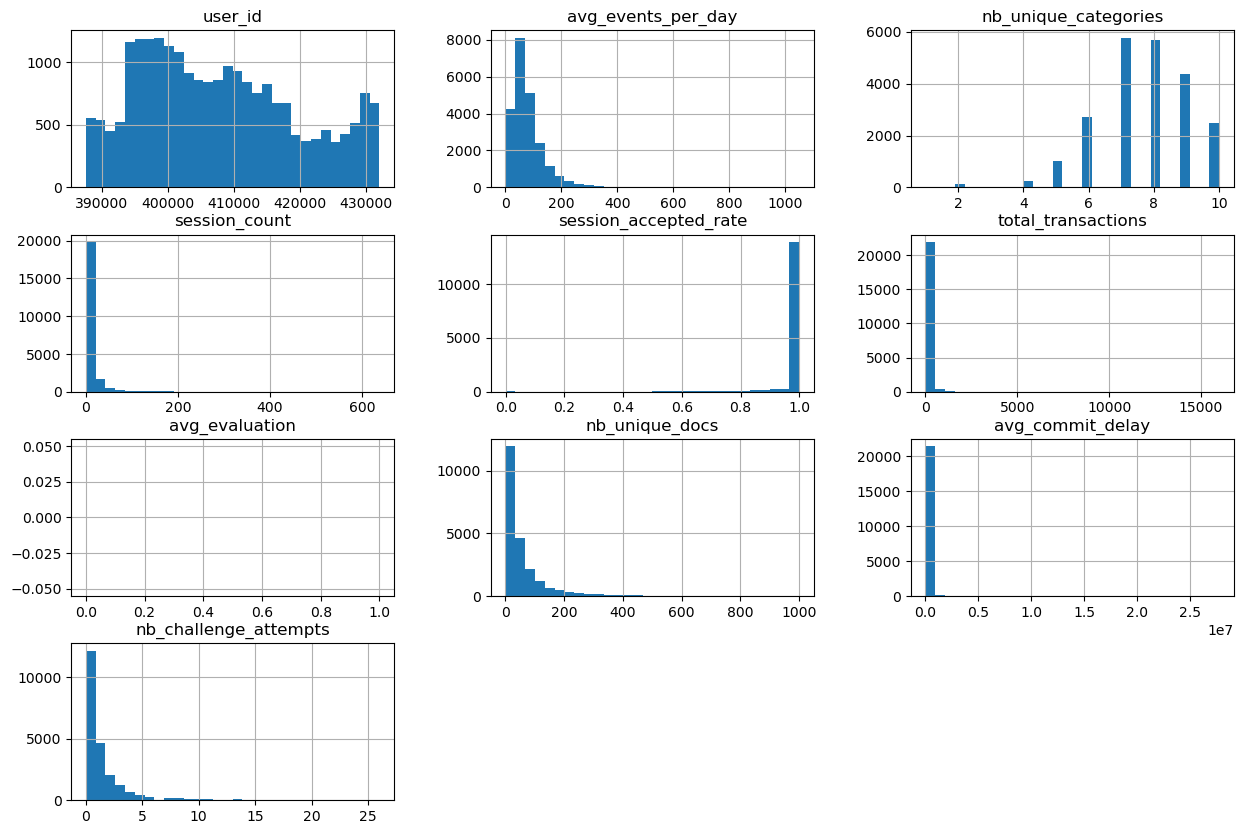

In [13]:
features_df.hist(figsize=(15, 10), bins=30)


NameError: name 'X_scaled' is not defined

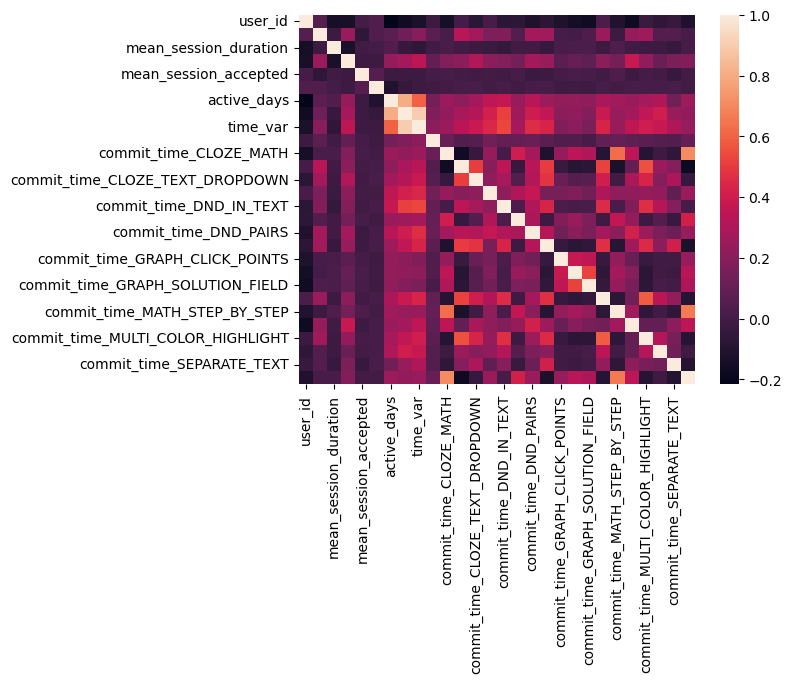

In [14]:
import numpy as np

# Exclude or drop avg_evaluation if it's too empty
features_df = features_df.drop(columns=['avg_evaluation'])

# Apply log transformation to skewed numerical variables
for col in ['avg_events_per_day', 'session_count', 'total_transactions', 'nb_unique_docs',
            'avg_commit_delay', 'nb_challenge_attempts']:
    features_df[f'log_{col}'] = np.log1p(features_df[col])  # log1p avoids log(0) error


array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'avg_events_per_day'}>,
        <Axes: title={'center': 'nb_unique_categories'}>,
        <Axes: title={'center': 'session_count'}>],
       [<Axes: title={'center': 'session_accepted_rate'}>,
        <Axes: title={'center': 'total_transactions'}>,
        <Axes: title={'center': 'nb_unique_docs'}>,
        <Axes: title={'center': 'avg_commit_delay'}>],
       [<Axes: title={'center': 'nb_challenge_attempts'}>,
        <Axes: title={'center': 'log_avg_events_per_day'}>,
        <Axes: title={'center': 'log_session_count'}>,
        <Axes: title={'center': 'log_total_transactions'}>],
       [<Axes: title={'center': 'log_nb_unique_docs'}>,
        <Axes: title={'center': 'log_avg_commit_delay'}>,
        <Axes: title={'center': 'log_nb_challenge_attempts'}>, <Axes: >]],
      dtype=object)

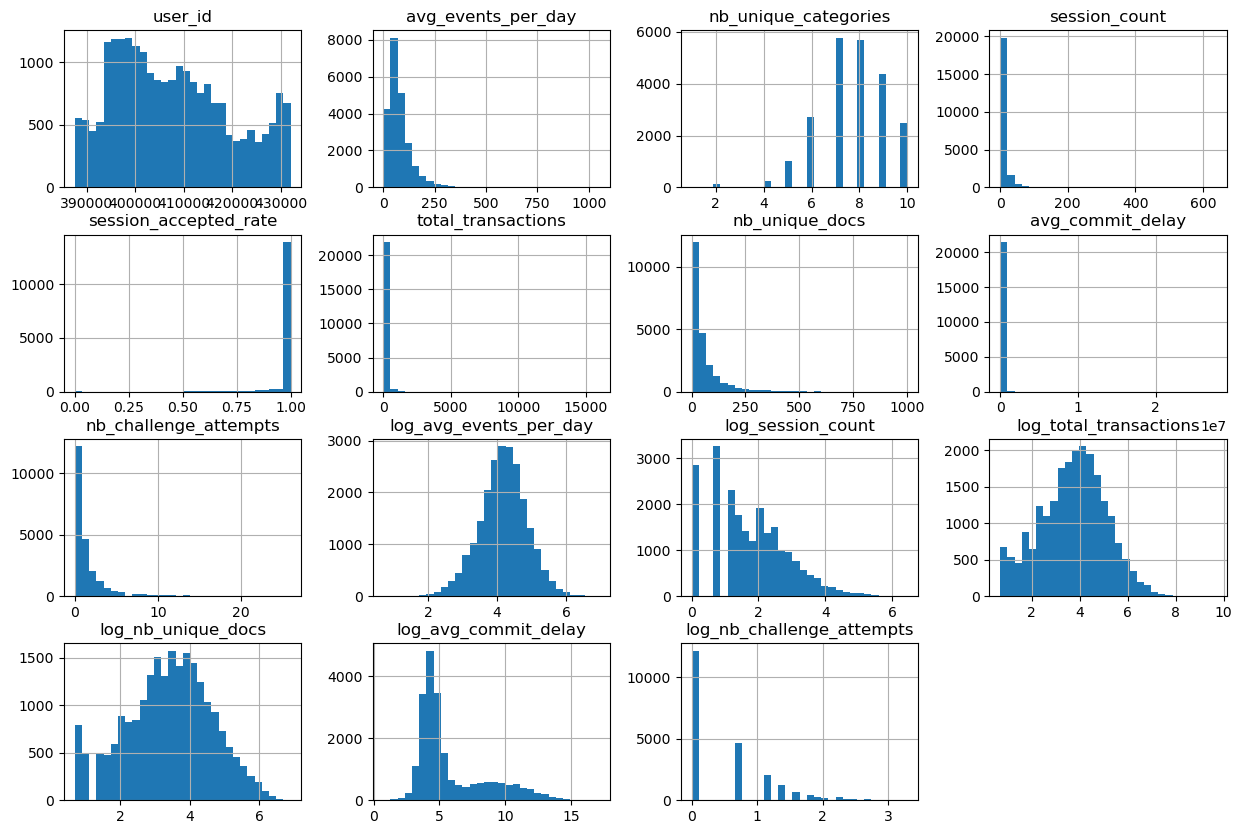

In [15]:
features_df.hist(figsize=(15, 10), bins=30)


*Your discussion about your processing decisions goes here*

## Task 2: Model Building

Train a model for your research question. 

*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [ ]:
# Your code for model evaluation goes here

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*